## Simulation of a QKD process invaded by Quantum Cloning Machine

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from getpass import getpass
from coreapi.auth import BasicAuthentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.credentials import load_account, get_token_authentication, get_basic_authentication
from quantuminspire.api import QuantumInspireAPI

In [2]:
print('Enter mail address')
email = input()

print('Enter password')
password = getpass()

server_url = r'https://api.quantum-inspire.com'
authentication = BasicAuthentication(email, password)
qi = QuantumInspireAPI(server_url, authentication)

Enter mail address
y.zhang-108@student.tudelft.nl
Enter password
········


In [3]:
qi.list_backend_types()

Backend type: Starmon-5, number of qubits: 5
Backend type: Spin-2, number of qubits: 2
Backend type: QX single-node simulator, number of qubits: 26
Backend type: QX single-node simulator SurfSara, number of qubits: 31


### BB84 protocol: Charles H. Bennett and Gilles Brassard (1984)

Bob generate the key and measurement bases

If base is 0, measure in Z, otherwise measure in X.

(key,base): state

00: $|0\rangle$ 
10: $|1\rangle$ 
01: $|+\rangle$ 
11: $|-\rangle$ 


Alice prepare the qubit and send it to Bob.

Assume Eve have a Cloning Machine and a Quantum Memory

So she can clone the states and measure in the same base after Bob publish her measurement bases.

In [4]:
def QKD_QACM(key,A_base,B_base,E_base):
    
    # here the qubits used in circuit is 1,3 instead of 0,4, for lower error rate
    
    qasm ='''
    version 2.0

    qubits 5

    # initialize the state
    {0}
    
    #preparation
    Ry q[0], 1.107149
    #rewrite CNOT q[0],q[4] and CNOT q[4],q[0] usign nearest neighbors
    SWAP q[0],q[2] 
    CNOT q[2],q[4]

    Ry q[4], 0.729728
    CNOT q[4],q[2]
    SWAP q[0],q[2]

    Ry q[0], 0.463648

    #copying
    CNOT q[2], q[0]
    CNOT q[2], q[4]
    CNOT q[0], q[2]
    CNOT q[4], q[2]

    #Rotate back and measure
    {1}
    {2}
    '''
    if A_base:
        prep="prep_x q[2]\n"
        if key:
            prep+="    Z q[2]\n"
    else:
        prep="prep_z q[2]\n"
        if key:
            prep+="    X q[2]\n"
            
    meas="measure_x q[2]\n" if B_base else "measure_z q[2]"
    invasion="measure_x q[0]\n" if E_base else "measure_z q[0]"
    
    return qasm.format(prep,meas,invasion)

In [5]:
def QKD_QACM_1SWAP(key,A_base,B_base,E_base):
    
    # here the qubits used in circuit is 1,3 instead of 0,4, for lower error rate    
    qasm = '''
    version 1.0

    qubits 5

    
    # initialize the state
    {0}
    
    #preparation
    Ry q[2], 1.107149
    #rewrite CNOT q[0],q[4] and CNOT q[4],q[0] usign nearest neighbors
    CNOT q[2],q[1]

    Ry q[1], 0.729728
    CNOT q[1],q[2]

    Ry q[2], 0.463648
    SWAP q[0],q[2]

    #copying
    CNOT q[2], q[0]
    CNOT q[2], q[1]
    CNOT q[0], q[2]
    CNOT q[1], q[2]


    #Rotate back and measure
    {1}
    {2}
    '''
    
    if A_base:
        prep="prep_x q[2]\n"
        if key:
            prep+="    Z q[2]\n"
    else:
        prep="prep_z q[2]\n"
        if key:
            prep+="    X q[2]\n"
            
    meas="measure_x q[2]\n" if B_base else "measure_z q[2]"
    invasion="measure_x q[0]\n" if E_base else "measure_z q[0]"
    
    return qasm.format(prep,meas,invasion)

In [6]:
def sample_error_rate(data_sheet,N):
    sample=data_sheet.sample(N)
    return sum(sample["m_Bob"]!=sample["key"])/N

In [7]:
def sample_series(data_sheet,N_series,M):
    L=len(N_series)
    means=np.zeros(L)
    devs=np.zeros(L)
    for i in range(L):
        samp=[sample_error_rate(data_sheet,N_series[i]) for m in range(M)]
        means[i]=np.mean(samp)
        devs[i]=np.std(samp)
    return means,devs

In [8]:
#[bin(int(i))[2:].zfill(5) for i in hist.keys()]
@np.vectorize
def to_XZ(i):
    return ("Z","X")[i]

Check the predetermined subset of their remained key to detect a eavesdropper.

If UQCM used, we can expect the error rate of key is 1/6. 

**QKD with 64 key length**

In [8]:
n_key=64
bitstring = np.random.randint(2,size=n_key)
bases_A=np.random.randint(2,size=n_key)
bases_B=bases_A.copy()
# bases_B=np.random.randint(2,size=n_key)
bases_E=bases_B.copy() # assume quantum memory

In [9]:
N_shots=1
backend_type = qi.get_backend_type_by_name('Starmon-5')
# backend_type = qi.get_backend_type_by_name('QX single-node simulator')

data=[]
index=0

for param in zip(bitstring,bases_A,bases_B,bases_E):
#     if index<146:
#         index+=1
#     else:
    qasm=QKD_QACM(*param)
    result = qi.execute_qasm(qasm, backend_type=backend_type, number_of_shots=N_shots)
    key=bin(int(list(result.get('histogram', {}).keys())[0]))[2:].zfill(5)
    hist=list(result.get('histogram', {}).values())
    data.append(key)
    index+=1

    print(str(index)+"/"+str(n_key))
    print("Execution time: ", result.get('execution_time_in_seconds',{}))
    print("key:{0},bases_Alice:{1},bases_Bob:{2},bases_Eve:{3}".format(*param))
    print(key)
    print(hist)

1/64
Execution time:  0.000152
key:1,bases_Alice:0,bases_Bob:0,bases_Eve:0
00000
[1.0]
2/64
Execution time:  0.000152
key:0,bases_Alice:0,bases_Bob:0,bases_Eve:0
00000
[1.0]
3/64
Execution time:  0.000152
key:1,bases_Alice:1,bases_Bob:1,bases_Eve:1
00001
[1.0]
4/64
Execution time:  0.000152
key:1,bases_Alice:1,bases_Bob:1,bases_Eve:1
00101
[1.0]
5/64
Execution time:  0.000152
key:0,bases_Alice:0,bases_Bob:0,bases_Eve:0
00000
[1.0]
6/64
Execution time:  0.000152
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00100
[1.0]
7/64
Execution time:  0.000152
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00000
[1.0]
8/64
Execution time:  0.000152
key:1,bases_Alice:1,bases_Bob:1,bases_Eve:1
00100
[1.0]
9/64
Execution time:  0.000152
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00000
[1.0]
10/64
Execution time:  0.000152
key:1,bases_Alice:1,bases_Bob:1,bases_Eve:1
00100
[1.0]
11/64
Execution time:  0.000152
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00001
[1.0]
12/64
Execution time:  0.000152
key:1,bas

In [10]:
len(data)

64

In [11]:
data_sheet=DataFramet=pd.DataFrame(\
    data=np.vstack([bitstring,to_XZ(bases_A),list(map(lambda x: x[2], np.array(data))),list(map(lambda x: x[4], np.array(data)))]).transpose(),\
    columns=["key","bases","m_Bob","m_Eve"])
data_sheet.head()

data_sheet.to_excel("QKD_Simulation_64.xlsx")

In [12]:
sum(data_sheet["m_Bob"]==data_sheet["key"])

45

<ErrorbarContainer object of 3 artists>

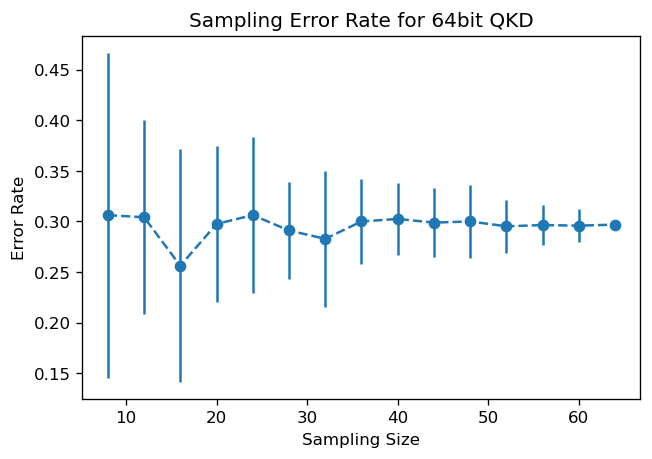

In [17]:
X=np.arange(8,65,4)
Y,std=sample_series(data_sheet,X,20)

plt.figure(dpi=120)
plt.xlabel("Sampling Size")
plt.ylabel("Error Rate")
plt.title("Sampling Error Rate for 64bit QKD")
plt.errorbar(x=X,y=Y,yerr=std,marker="o",linestyle='--')


**QKD with 128 bit length**

In [341]:
n_key=128
bitstring = np.random.randint(2,size=n_key)
bases_A=np.random.randint(2,size=n_key)
bases_B=bases_A.copy()
# bases_B=np.random.randint(2,size=n_key)
bases_E=bases_B.copy() # assume quantum memory

The expection key length is 1/2 of the random bitstring.

In [340]:
sum(bases_A==bases_B)

128

In [343]:
N_shots=1
backend_type = qi.get_backend_type_by_name('Starmon-5')
# backend_type = qi.get_backend_type_by_name('QX single-node simulator')

data=[]
index=0

for param in zip(bitstring,bases_A,bases_B,bases_E):
    qasm=QKD_QACM(*param)
    result = qi.execute_qasm(qasm, backend_type=backend_type, number_of_shots=N_shots)
    key=bin(int(list(result.get('histogram', {}).keys())[0]))[2:].zfill(5)
    hist=list(result.get('histogram', {}).values())
    data.append(key)
    index+=1
    
    print(str(index)+"/"+str(n_key))
    print("Execution time: ", result.get('execution_time_in_seconds',{}))
    print("key:{0},bases_Alice:{1},bases_Bob:{2},bases_Eve:{3}".format(*param))
    print(key)
    print(hist)

1/128
Execution time:  0.000152
key:0,bases_Alice:0,bases_Bob:0,bases_Eve:0
00100
[1.0]
2/128
Execution time:  0.000152
key:1,bases_Alice:1,bases_Bob:1,bases_Eve:1
00100
[1.0]
3/128
Execution time:  0.000152
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00001
[1.0]
4/128
Execution time:  0.000152
key:1,bases_Alice:1,bases_Bob:1,bases_Eve:1
00101
[1.0]
5/128
Execution time:  0.000152
key:0,bases_Alice:0,bases_Bob:0,bases_Eve:0
00000
[1.0]
6/128
Execution time:  0.000152
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00001
[1.0]
7/128
Execution time:  0.000152
key:0,bases_Alice:0,bases_Bob:0,bases_Eve:0
00101
[1.0]
8/128
Execution time:  0.000152
key:0,bases_Alice:0,bases_Bob:0,bases_Eve:0
00100
[1.0]
9/128
Execution time:  0.000152
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00000
[1.0]
10/128
Execution time:  0.000152
key:0,bases_Alice:0,bases_Bob:0,bases_Eve:0
00000
[1.0]
11/128
Execution time:  0.000152
key:0,bases_Alice:0,bases_Bob:0,bases_Eve:0
00000
[1.0]
12/128
Execution time:  0.0001

94/128
Execution time:  0.000152
key:1,bases_Alice:0,bases_Bob:0,bases_Eve:0
00100
[1.0]
95/128
Execution time:  0.000152
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00001
[1.0]
96/128
Execution time:  0.000152
key:1,bases_Alice:1,bases_Bob:1,bases_Eve:1
00001
[1.0]
97/128
Execution time:  0.000152
key:0,bases_Alice:0,bases_Bob:0,bases_Eve:0
00000
[1.0]
98/128
Execution time:  0.000152
key:1,bases_Alice:0,bases_Bob:0,bases_Eve:0
00101
[1.0]
99/128
Execution time:  0.000152
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00001
[1.0]
100/128
Execution time:  0.000152
key:1,bases_Alice:0,bases_Bob:0,bases_Eve:0
00101
[1.0]
101/128
Execution time:  0.000152
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00001
[1.0]
102/128
Execution time:  0.000152
key:1,bases_Alice:1,bases_Bob:1,bases_Eve:1
00100
[1.0]
103/128
Execution time:  0.000152
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00100
[1.0]
104/128
Execution time:  0.000152
key:1,bases_Alice:0,bases_Bob:0,bases_Eve:0
00100
[1.0]
105/128
Executio

In [351]:
data_sheet_128=DataFramet=pd.DataFrame(\
    data=np.vstack([bitstring,to_XZ(bases_A),list(map(lambda x: x[2], np.array(data))),list(map(lambda x: x[4], np.array(data)))]).transpose(),\
    columns=["key","bases","m_Bob","m_Eve"])
data_sheet_128.head()

,key,bases,m_Bob,m_Eve
0,0,Z,1,0
1,1,X,1,0
2,0,X,0,1
3,1,X,1,1
4,0,Z,0,0


In [352]:
data_sheet_128.to_excel("QKD_Simulation_128.xlsx")

In [2]:
data_sheet_128=pd.read_excel("QKD_Simulation_128.xlsx")

In [6]:
sum(data_sheet_128["m_Bob"]==data_sheet_128["key"])

87

In [7]:
87/128

0.6796875

In [66]:
X=np.arange(8,65,4)
Y,std=sample_series(data_sheet_128,X,20)

<ErrorbarContainer object of 3 artists>

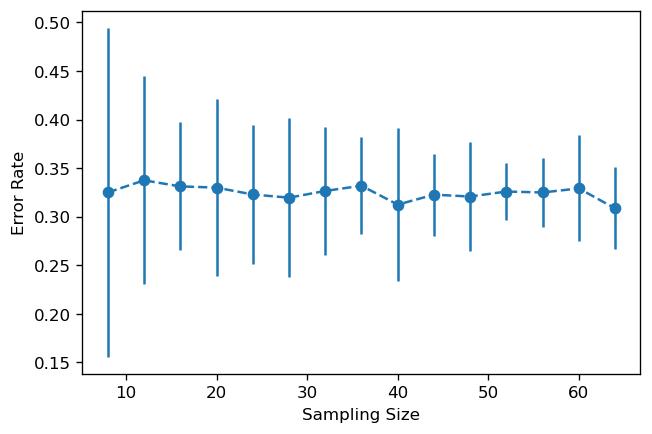

In [67]:
plt.figure(dpi=120)
plt.xlabel("Sampling Size")
plt.ylabel("Error Rate")
plt.errorbar(x=X,y=Y,yerr=std,marker="o",linestyle='--')

In [68]:
(Y.mean(),Y.std())

(0.32463993529618523, 0.007156819033395263)

**QKD with 145 bit length**

In [69]:
data_sheet_145=pd.read_excel("QKD_Simulation_145.xlsx")

<ErrorbarContainer object of 3 artists>

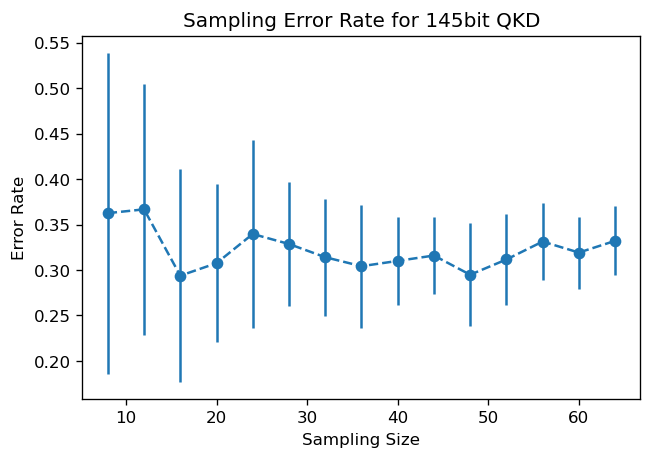

In [70]:
X=np.arange(8,65,4)
Y,std=sample_series(data_sheet_145,X,20)

plt.figure(dpi=120)
plt.xlabel("Sampling Size")
plt.ylabel("Error Rate")
plt.title("Sampling Error Rate for 145bit QKD")
plt.errorbar(x=X,y=Y,yerr=std,marker="o",linestyle='--')


In [71]:
(Y.mean(),Y.std())

(0.3220991820679321, 0.020979303517410383)

Find the key by take same measurement bases

In [357]:
data_sheet_64=pd.read_excel("QKD_Simulation_64.xlsx")
secure_key=bitstring[bases_A==bases_B]
prob=data_sheet_64[bases_A==bases_B]

In [5]:
data_sheet_145=pd.read_excel("QKD_Simulation_145.xlsx")

In [6]:
data_sheet_145.to_csv("QKD_Simulation_145.csv")

**QKD with 1SWAP UQCM**

In [ ]:
n_key=64
bitstring = np.random.randint(2,size=n_key)
bases_A=np.random.randint(2,size=n_key)
bases_B=bases_A.copy()
# bases_B=np.random.randint(2,size=n_key)
bases_E=bases_B.copy() # assume quantum memory

In [22]:
N_shots=1
backend_type = qi.get_backend_type_by_name('Starmon-5')
# backend_type = qi.get_backend_type_by_name('QX single-node simulator')

data=[]
index=0

for param in zip(bitstring,bases_A,bases_B,bases_E):
#     if index<146:
#         index+=1
#     else:
    qasm=QKD_QACM_1SWAP(*param)
    result = qi.execute_qasm(qasm, backend_type=backend_type, number_of_shots=N_shots)
    key=bin(int(list(result.get('histogram', {}).keys())[0]))[2:].zfill(5)
    hist=list(result.get('histogram', {}).values())
    data.append(key)
    index+=1

    print(str(index)+"/"+str(n_key))
    print("Execution time: ", result.get('execution_time_in_seconds',{}))
    print("key:{0},bases_Alice:{1},bases_Bob:{2},bases_Eve:{3}".format(*param))
    print(key)
    print(hist)

1/64
Execution time:  0.000152
key:1,bases_Alice:0,bases_Bob:0,bases_Eve:0
00101
[1.0]
2/64
Execution time:  0.000152
key:0,bases_Alice:0,bases_Bob:0,bases_Eve:0
00000
[1.0]
3/64
Execution time:  0.000152
key:1,bases_Alice:1,bases_Bob:1,bases_Eve:1
00000
[1.0]
4/64
Execution time:  0.000152
key:1,bases_Alice:1,bases_Bob:1,bases_Eve:1
00000
[1.0]
5/64
Execution time:  0.000152
key:0,bases_Alice:0,bases_Bob:0,bases_Eve:0
00000
[1.0]
6/64
Execution time:  0.000152
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00100
[1.0]
7/64
Execution time:  0.000152
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00000
[1.0]
8/64
Execution time:  0.000152
key:1,bases_Alice:1,bases_Bob:1,bases_Eve:1
00100
[1.0]
9/64
Execution time:  0.000152
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00000
[1.0]
10/64
Execution time:  0.000152
key:1,bases_Alice:1,bases_Bob:1,bases_Eve:1
00100
[1.0]
11/64
Execution time:  0.000152
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00001
[1.0]
12/64
Execution time:  0.000152
key:1,bas

In [23]:
data_sheet=DataFramet=pd.DataFrame(\
    data=np.vstack([bitstring,to_XZ(bases_A),list(map(lambda x: x[2], np.array(data))),list(map(lambda x: x[4], np.array(data)))]).transpose(),\
    columns=["key","bases","m_Bob","m_Eve"])
data_sheet.head()

data_sheet.to_excel("QKD_Simulation_64_1SWAP.xlsx")

In [9]:
data_sheet=pd.read_excel("QKD_Simulation_64_1SWAP.xlsx")

<ErrorbarContainer object of 3 artists>

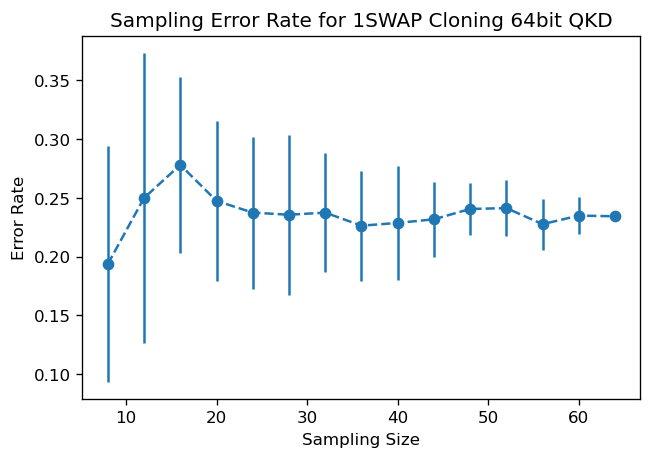

In [12]:
X=np.arange(8,65,4)
Y,std=sample_series(data_sheet,X,20)

plt.figure(dpi=120)
plt.xlabel("Sampling Size")
plt.ylabel("Error Rate")
plt.title("Sampling Error Rate for 1SWAP Cloning 64bit QKD")
plt.errorbar(x=X,y=Y,yerr=std,marker="o",linestyle='--')


In [14]:
Y.mean(),Y.std()

(0.23640473877973872, 0.016683794332560637)

Assume Alice and Bob preserve half of the key for secure check.

Find the probability of Eve get the key without being noticed.

In [237]:
def get_success_prob(bit_string,probs,p):
    '''
    prob: npndarray for probability distribution
    p: number of bit to be check in public channel
    '''
    res=1
    undetected=1
    
    for (k,p) in zip(key[:p],probs[:p]):
        res*=p[k*3] # with 00 or 11
        undetected*=p[k*x3]+p[k+1] # k+1=01 or 10
    return res,undetected

In [354]:
sum(daxta_sheet["m_Bob"]==data_sheet["key"])

87

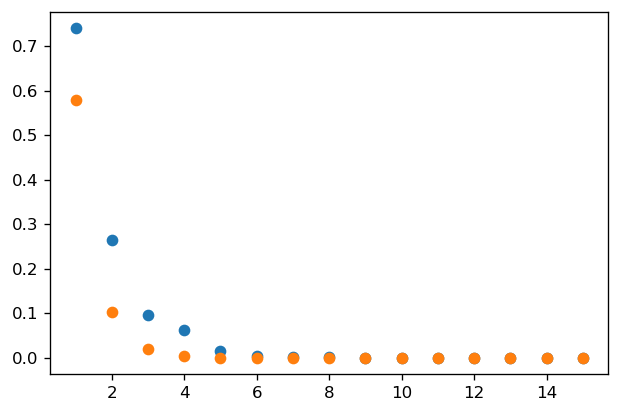

In [319]:
f=plt.figure()
f.dpi=120
plt.scatter(x=np.arange(1,m),y=eve_probs[:,1])
plt.scatter(x=np.arange(1,m),y=eve_probs[:,0])

In [306]:
m=16
eve_probs=[]

for i in range(1,m):
    p=get_success_prob(secure_key,prob.values,i)
    eve_probs.append(p)
    print(p)
    
eve_probs=np.array(eve_probs)

(0.5799815781393921, 0.7396377034080442)
(0.10189331530332366, 0.26538130440354024)
(0.019139051871814135, 0.09623620163029452)
(0.005170317781023412, 0.06175853635057161)
(0.0003814048149487507, 0.015866191907780002)
(2.8283679784550892e-05, 0.004206409248625315)
(5.033384432842812e-06, 0.0014705116562642015)
(1.3115545927424025e-06, 0.0009189688439476449)
(2.416565155131671e-07, 0.000326197759725668)
(1.0124071438218507e-07, 0.00024252274634403603)
(2.5975705204034735e-08, 0.00015295358863052152)
(1.0645488254350202e-08, 0.00011212743323171863)
(2.5473805521914113e-09, 7.065020571768466e-05)
(2.381619813193167e-10, 1.8600502926421095e-05)
(8.170069122581292e-11, 1.0529194097414363e-05)
